# Noiseless Quantum Circuit Simulation for Two-Probe System

This notebook runs a noiseless simulation of the two-probe quantum system using measurement outcomes sampled from a classical representation of the wavefunction. We simulate the full quantum circuit exactly, then sample measurement outcomes probabilistically from the resulting quantum state. This contrasts with the 'decode' files which use similar tensor network methods but operate on experimentally generated measurement outcomes from real quantum hardware.

**Data Storage Format:**
- `vndata_{L}_d={distance}.pt`: Von Neumann entropy values, tensor shape (len(thetas), num_samples)
- `ndata_{L}_d={distance}.pt`: Negativity values, tensor shape (len(thetas), num_samples)
- Each theta slice contains samples across different random measurement basis choices
- L = lattice size, d = distance parameter for probe separation
- Data is generated by running the MIPT_sqr model with varying rotation angles θ ∈ [0, π/2]


In [10]:
import torch
from matplotlib import pyplot as plt

dtype = torch.complex128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MIPT_sqr(torch.nn.Module):
    '''
    Shallow circuit on square lattice
    '''
    def __init__(self, L, theta, phi):
        super().__init__()
        self.L = L
        postHadamard = torch.ones((2**L), dtype=dtype, device=device)
        postHadamard = postHadamard/torch.norm(postHadamard)
        # store UZZcol for 2L
        idx = torch.arange(2**(2*L))
        mask = 2**torch.arange((2*L) - 1, -1, -1, dtype=idx.dtype)
        config = (idx.unsqueeze(-1) & mask) != 0
        config = config.int()
        Zsigns = config*2 - 1
        HZZcol = 0.
        for i in range(L):
            HZZcol += Zsigns[:,i] * Zsigns[:,i+L]
        UZZcol = torch.exp(1.0j*(torch.pi/4)*HZZcol)
        self.UZZcol = UZZcol.to(dtype).to(device)
        # store UZZrow for 1L
        idx = torch.arange(2**(L))
        mask = 2**torch.arange((L) - 1, -1, -1, dtype=idx.dtype)
        config = (idx.unsqueeze(-1) & mask) != 0
        config = config.int()
        Zsigns = config*2 - 1
        HZZrow_L = 0.
        for i in range(L-1):
            HZZrow_L += Zsigns[:,i] * Zsigns[:,i+1]
        UZZrow_L = torch.exp(1.0j*(torch.pi/4)*HZZrow_L)
        self.UZZrow_L = UZZrow_L.to(dtype).to(device)
        psi0 = self.UZZrow_L * postHadamard
        self.psi0 = psi0
        # store single qubit rotation
        theta, phi = torch.tensor(theta), torch.tensor(phi)
        # single qubit rotation
        U = torch.tensor([[torch.cos(theta/2)*torch.exp(1.0j*phi/2),torch.sin(theta/2)*torch.exp(-1.0j*phi/2)],
                          [-torch.sin(theta/2)*torch.exp(1.0j*phi/2),torch.cos(theta/2)*torch.exp(-1.0j*phi/2)]])
        self.U = U.to(dtype).to(device)
        # store Paulis
        pauli = torch.tensor([[[1,0],[0,1]],[[0,1],[1,0]],[[0,-1j],[1j,0]],[[1,0],[0,-1]]], device=device, dtype=dtype)
        basis = torch.linalg.eig(pauli)[1][1:].mT # (3, 2, 2)
        C4 = torch.linalg.eig(pauli)[1][1:].conj() # (3, 2, 2)
        # Registering the tensors as buffers
        self.register_buffer('pauli', pauli)
        self.register_buffer('basis', basis)
        self.register_buffer('C4', C4)
        
    def step(self, psi):
        psi0 = self.psi0.unsqueeze(0).expand(psi.shape[0], -1)
        psi = torch.vmap(torch.kron)(psi, psi0)
        # act with Ising interactions:
        psi = self.UZZcol.unsqueeze(0).expand(psi.shape[0], -1) * psi
        psi = psi.view((psi.shape[0],)+(2,)*self.L*2)
        # act with U:
        for i in range(1, self.L+1):
            psi = torch.swapaxes(psi, 0, i)
            psi = torch.tensordot(self.U, psi, dims=([1],[0]))
            psi = torch.swapaxes(psi, 0, i)
        # measure first row
        psi = psi.reshape(-1, 2**self.L, 2**self.L)
        probs = (psi * psi.conj()).sum(-1).real
        idx = torch.multinomial(probs, num_samples=1) # (batch, 1)
        # store outcomes
        mask = 2**torch.arange(self.L - 1, -1, -1, device=device, dtype=idx.dtype)
        outcomes = (idx & mask) != 0
        outcomes = outcomes.int()
        # collapse state
        idx = idx.expand(-1, psi.shape[2])
        psi = torch.gather(psi, 1, idx.unsqueeze(1)).squeeze(1)
        psi /= torch.norm(psi, dim=-1, keepdim=True)
        return psi.contiguous(), outcomes
    
    def measure_mid(self, psi):
        psi = psi.view((psi.shape[0],)+(2,)*self.L)
        # act with U:
        for i in range(1, self.L+1):
            psi = torch.swapaxes(psi, 0, i)
            psi = torch.tensordot(self.U, psi, dims=([1],[0]))
            psi = torch.swapaxes(psi, 0, i)
        # swap probe qubits to last 2 positions
        #psi = psi.permute([0]+list(range(2,self.L))+[1,self.L]) #torch.swapaxes(psi, 1, -2)
        psi = psi.permute([0,6,2,3,4,5,1]) #torch.swapaxes(psi, 1, -2)
        psi = psi.reshape(-1, 2**(self.L-2), 4)
        probs = (psi * psi.conj()).sum(-1).real
        idx = torch.multinomial(probs, num_samples=1) # (batch, 1)
        # store outcomes
        mask = 2**torch.arange(self.L - 3, -1, -1, device=device, dtype=idx.dtype)
        outcomes = (idx & mask) != 0
        outcomes = outcomes.int()
        # collapse state
        idx = idx.expand(-1, psi.shape[2])
        psi = torch.gather(psi, 1, idx.unsqueeze(1)).squeeze(1)
        psi /= torch.norm(psi, dim=-1, keepdim=True)
        return psi, outcomes
    
    def run(self, batch=1, pad=False):
        all_outcomes = []
        psi = self.psi0[None,...].expand(batch, -1)
        for _ in range(self.L-1):
            psi, outcomes = self.step(psi)
            all_outcomes.append(outcomes)
        psi, outcomes = self.measure_mid(psi)
        if pad:
            outcomes = torch.cat([outcomes, 2*torch.ones(batch, 1, dtype=outcomes.dtype, device=outcomes.device)], -1)
            outcomes = torch.cat([2*torch.ones(batch, 1, dtype=outcomes.dtype, device=outcomes.device), outcomes], -1)
        all_outcomes.append(outcomes)
        all_outcomes = torch.cat(all_outcomes, -1)
        return torch.vmap(torch.outer)(psi,psi.conj()), all_outcomes
    
    def get_data(self, batch, pad=False):
        psi, all_outcomes = self.run(batch, pad)
        # get shadow of probes
        obsseq = torch.randint(3, (batch, 2), device=device)
        state = psi.reshape(-1, 2, 2)
        for i in range(2):
            state = torch.swapaxes(state, 1, i+1) # put target site to the first place
            U = self.C4[obsseq[:,i]] # (batch, 2, 2)
            state = torch.bmm(U, state)
            state = torch.swapaxes(state, 1, i+1) # put target site back
        # sample for outcomes
        probs = (state.conj() * state).reshape(obsseq.shape[0], -1).real # (batch, 4)
        idx = torch.multinomial(probs, num_samples=1) # (batch, )
        mask = 2**torch.arange(1, -1, -1, device=device, dtype=idx.dtype)
        outseq = (idx & mask) != 0 # (batch, 2)
        outseq = outseq.to(torch.int64)
        # construct shadows
        obs_basis0 = self.basis[obsseq[:,0]] # (batch, 2, 2)
        shadow_state0 = obs_basis0.gather(1, outseq[:,0].view(-1, 1, 1).expand(-1, -1, 2)).squeeze(1) # (batch, 2)
        obs_basis1 = self.basis[obsseq[:,1]] # (batch, 2, 2)
        shadow_state1 = obs_basis1.gather(1, outseq[:,1].view(-1, 1, 1).expand(-1, -1, 2)).squeeze(1) # (batch, 2)
        shadow_state = torch.vmap(torch.kron)(shadow_state0, shadow_state1) # (batch, 4)
        # construct rhoS
        I = torch.eye(2, 2, device=device)[None,...].expand(batch, -1, -1)
        rhoS0 = 3*torch.vmap(torch.outer)(shadow_state0, shadow_state0.conj()) - I
        rhoS1 = 3*torch.vmap(torch.outer)(shadow_state1, shadow_state1.conj()) - I
        rhoS = torch.vmap(torch.kron)(rhoS0, rhoS1)
        # if pad:
        #     all_outcomes = all_outcomes.view(batch, 1, self.L, self.L)
        return all_outcomes, shadow_state, rhoS#, torch.vmap(torch.outer)(psi, psi.conj())
    
def Neg(rho):
    rho_pt = rho.view(-1,2,2,2,2).permute(0,1,4,3,2).reshape(-1,4,4)
    e, v = torch.linalg.eig(rho_pt)
    mask = e.real < 0
    negative_v = v * mask.unsqueeze(1)
    P = torch.bmm(negative_v, negative_v.mT.conj()) # projection matrix
    return -torch.vmap(torch.trace)(torch.bmm(P, rho_pt)).real

In [26]:
thetas = torch.linspace(0,torch.pi/2,11)
batch, R = 1, 1
L = 12

vndata = []
ndata = []
for t in thetas:
    for i in range(int(R/batch)):
        mdl = MIPT_sqr(L=L, phi=5*torch.pi/4, theta=t.item())
        rho, psi = mdl.run(batch)
        eig = torch.linalg.eigh(torch.einsum('bikjk->bij', rho.view(-1,2,2,2,2)))[0]
        eig += 1e-5
        vn = -(eig*eig.log2()).sum(-1) # (batch)
        vndata.append(vn.tolist())
        ndata.append(Neg(rho).tolist())
vndata = torch.tensor(vndata).view(len(thetas), -1)
ndata = torch.tensor(ndata).view(len(thetas), -1)

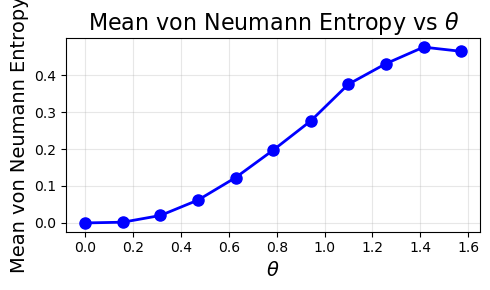

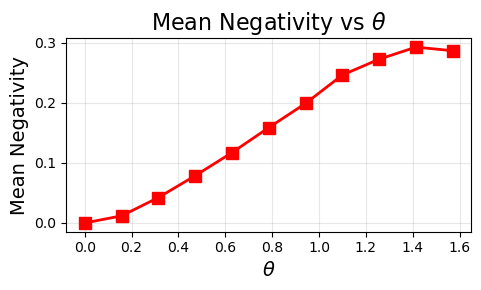

In [7]:
# Figure 1: von Neumann Entropy
plt.figure(figsize=(5, 3))
plt.plot(thetas, torch.load(f'vndata_{L}_d=4.pt').mean(1), 'o-', color='blue', linewidth=2, markersize=8)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Mean von Neumann Entropy', fontsize=14)
plt.title('Mean von Neumann Entropy vs $\\theta$', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 2: Negativity
plt.figure(figsize=(5, 3))
plt.plot(thetas, torch.load(f'ndata_{L}_d=4.pt').mean(1), 's-', color='red', linewidth=2, markersize=8)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Mean Negativity', fontsize=14)
plt.title('Mean Negativity vs $\\theta$', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [2]:
thetas = torch.linspace(0,torch.pi/2,11)
batch, R = 1, 200
for L in [12]:
    vndata = []
    ndata = []
    for t in thetas:
        for i in range(int(R/batch)):
            mdl = MIPT_sqr(L=L, phi=5*torch.pi/4, theta=t.item())
            rho, psi = mdl.run(batch)
            eig = torch.linalg.eigh(torch.einsum('bikjk->bij', rho.view(-1,2,2,2,2)))[0]
            eig += 1e-5
            vn = -(eig*eig.log2()).sum(-1) # (batch)
            vndata.append(vn.tolist())
            ndata.append(Neg(rho).tolist())
    vndata = torch.tensor(vndata).view(len(thetas), -1)
    ndata = torch.tensor(ndata).view(len(thetas), -1)
    torch.save(torch.cat([torch.load(f'vndata_{L}.pt'), vndata],-1), f'vndata_{L}.pt')
    torch.save(torch.cat([torch.load(f'ndata_{L}.pt'), ndata],-1), f'ndata_{L}.pt')
    # torch.save(vndata, f'vndata_{L}.pt')
    # torch.save(ndata, f'ndata_{L}.pt')

In [11]:
thetas = torch.linspace(0,torch.pi/2,11)
batch, R = 50, 1000
for L in [6]:
    vndata = []
    ndata = []
    for t in thetas:
        for i in range(int(R/batch)):
            mdl = MIPT_sqr(L=L, phi=5*torch.pi/4, theta=t.item())
            rho, psi = mdl.run(batch)
            eig = torch.linalg.eigh(torch.einsum('bikjk->bij', rho.view(-1,2,2,2,2)))[0]
            eig += 1e-5
            vn = -(eig*eig.log2()).sum(-1) # (batch)
            vndata.append(vn.tolist())
            ndata.append(Neg(rho).tolist())
    vndata = torch.tensor(vndata).view(len(thetas), -1)
    ndata = torch.tensor(ndata).view(len(thetas), -1)
    # torch.save(torch.cat([torch.load(f'vndata_{L}.pt'), vndata],-1), f'vndata_{L}.pt')
    # torch.save(torch.cat([torch.load(f'ndata_{L}.pt'), ndata],-1), f'ndata_{L}.pt')
    torch.save(vndata, f'vndata_{L}_d=5.pt')
    torch.save(ndata, f'ndata_{L}_d=5.pt')